### Notebook for running SONATA on x_branch dataset
Below, we replicate our results for x_branch dataset reported in *Securing diagonal integration of multimodal single-cell data against ambiguous mapping*




In [1]:
import os
import yaml
from sklearn.preprocessing import normalize

import sys
sys.path.insert(1, '../src/')
import sonata
from run_baselines.scot import scotv1
from utils.utils import *
from utils.vis import *

In [2]:
# load parameters and datasets
with open("./cfgs/x_branch.yaml", "r") as file:
        params = yaml.safe_load(file)
        
data_url1 = os.path.join(params["data_path"], params["data_url1"])
data_url2 = os.path.join(params["data_path"], params["data_url2"])
assert os.path.isfile(data_url1) and os.path.isfile(data_url2)

label_url1 = os.path.join(params["data_path"], params["label_url1"])
label_url2 = os.path.join(params["data_path"], params["label_url2"])
assert os.path.isfile(label_url1) and os.path.isfile(label_url2)

data1 = load_data(data_url1, )
data2 = load_data(data_url2, )
print("data size: data1 = {}, data2 = {}".format(data1.shape, data2.shape))

label1 = load_data(label_url1, ).astype(int)
label2 = load_data(label_url2, ).astype(int)

if params["norm"]: 
        data1 = normalize(data1, norm=params["norm"])
        data2 = normalize(data2, norm=params["norm"])

if params["sort_label"]: 
        data1, label1, _ = sorted_by_label(data1, label1)
        data2, label2, _ = sorted_by_label(data2, label2)

save_path = params["save_dir"]
print("data1 shape={}\tdata2 shape={}".format(data1.shape, data2.shape))
print("label1 shape={}\tlabel2 shape={}".format(label1.shape, label2.shape))


data size: data1 = (300, 1000), data2 = (300, 2000)
data1 shape=(300, 1000)	data2 shape=(300, 2000)
label1 shape=(300,)	label2 shape=(300,)


### 1. visualize two modalities

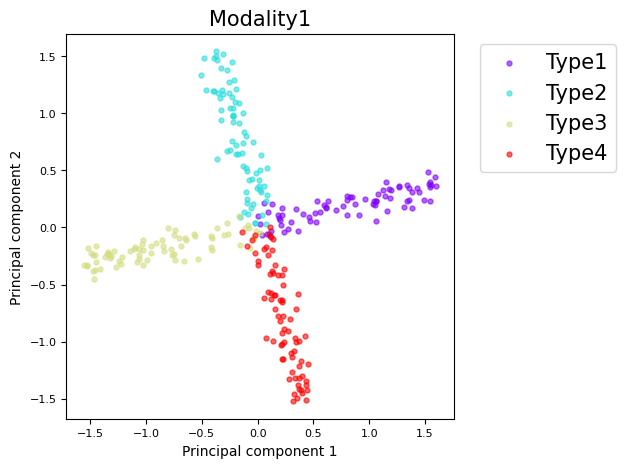

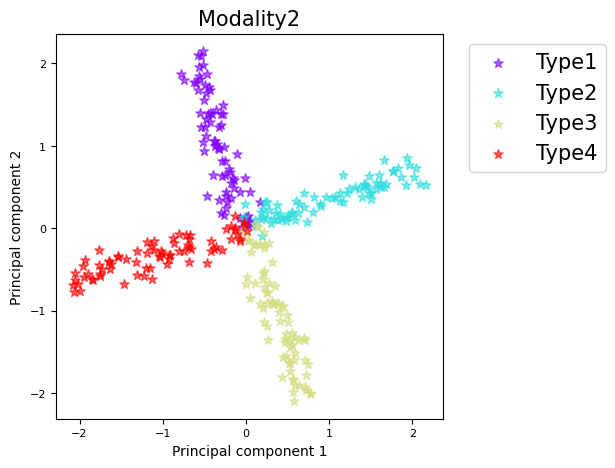

In [3]:
plt_domain_by_labels(data1, label1, title='Modality1', marker='.', a=0.6, show=True)
plt_domain_by_labels(data2, label2, title='Modality2', marker='*', a=0.6, show=True)

### 2. SONATA Diagnose

In [4]:
sn1 = sonata.sonata(params)
DiagnoseResult1 = sn1.diagnose(data1, save_dir=os.path.join(params['save_dir'], "Modality1"))

/Users/h46zhou/Documents/anaconda3/envs/sonata_public/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


---------------Coupling Denoising Iter=0--------------
Load_path = ../results/sonata_pipeline/x_branch/Modality1/coupling_iters/coupling_iter0.txt
---------------Coupling Denoising Iter=1--------------
Load_path = ../results/sonata_pipeline/x_branch/Modality1/coupling_iters/coupling_iter1.txt
---------------Coupling Denoising Iter=2--------------
Load_path = ../results/sonata_pipeline/x_branch/Modality1/coupling_iters/coupling_iter2.txt
---------------Coupling Denoising Iter=3--------------
Load_path = ../results/sonata_pipeline/x_branch/Modality1/coupling_iters/coupling_iter3.txt
---------------Coupling Denoising Iter=4--------------
Load_path = ../results/sonata_pipeline/x_branch/Modality1/coupling_iters/coupling_iter4.txt
---------------Coupling Denoising Iter=5--------------
Load_path = ../results/sonata_pipeline/x_branch/Modality1/coupling_iters/coupling_iter5.txt
---------------Coupling Denoising Iter=6--------------
Load_path = ../results/sonata_pipeline/x_branch/Modality1/coupl

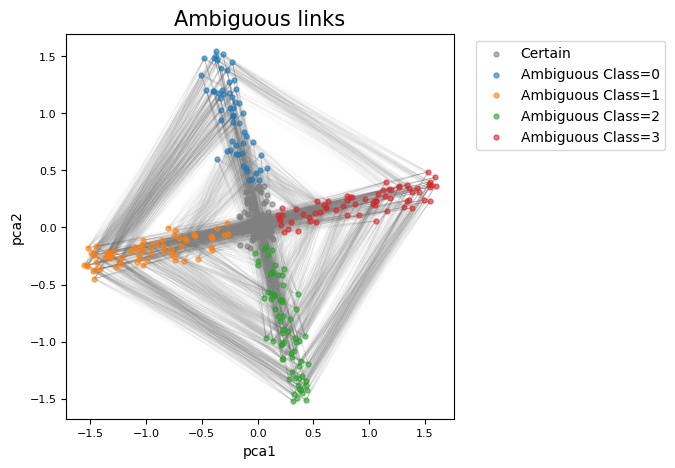

In [5]:
plt_cannotlink_by_labelcolor(data1, DiagnoseResult1.ambiguous_idx, DiagnoseResult1.ambiguous_labels, DiagnoseResult1.cannot_links, alpha=0.6, cl_alpha = 0.1, show=True)

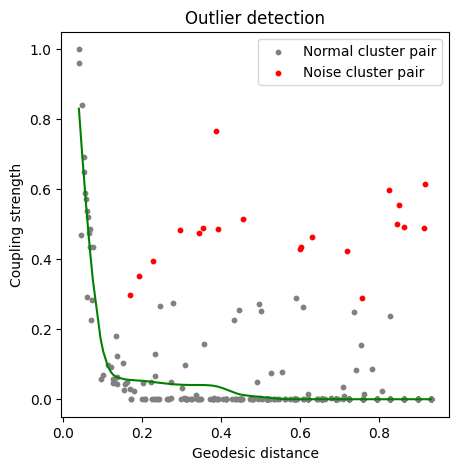

In [6]:
scatter_x = sn1.spline_data.spline_dist
scatter_y = sn1.spline_data.spline_coupling
include_indices = sn1.spline_data.include_indices
exclude_indices = sn1.spline_data.exclude_indices
spline_x = sn1.spline_data.spline_x
spline_y = sn1.spline_data.spline_y
        
plt_fit_spline(scatter_x, scatter_y, include_indices, exclude_indices, spline_x, spline_y, title="Outlier detection", show=True)

### 3. Mapping by SCOT v1 (or any other manifold aligners)

/Users/h46zhou/Documents/anaconda3/envs/sonata_public/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


It.  |Err         
-------------------
    0|7.919198e-03|
   10|1.753192e-08|
   20|3.304191e-15|


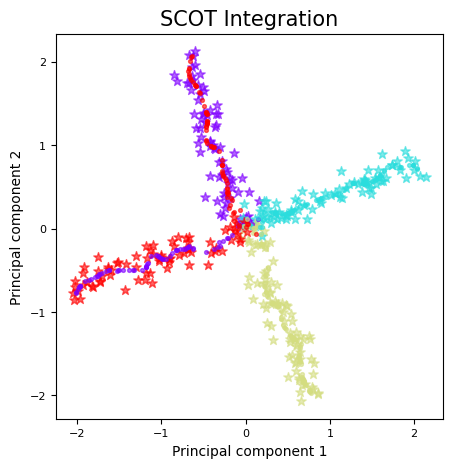

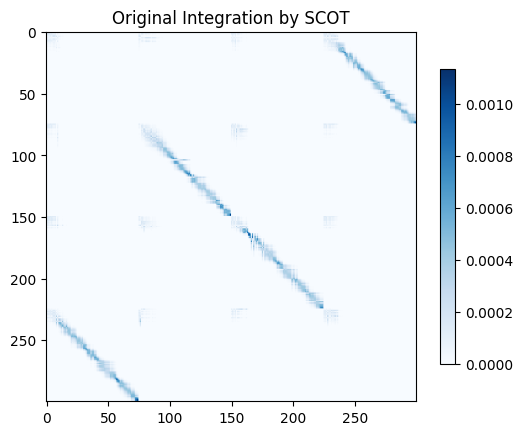

In [7]:
scot = scotv1.SCOT(data1.copy(), data2.copy())
x_aligned, y_aligned = scot.align(k = params["scot_k"], e=params["scot_e"], mode=params["scot_mode"], metric=params["scot_metric"], normalize=params["norm"])
mapping = scot.coupling

plt_mapping_by_labels(x_aligned, y_aligned, label1, label2, title = "SCOT Integration", a = 0.6, show=True)   
plt_heatmap(mapping, title="Original Integration by SCOT", show=True)

#### 4. SONATA Corrects the Ambiguous Alignment
We correct ambiguous alignments using the diagnostic results from modality 1 for illustration, though both diagonal results can also be checked.

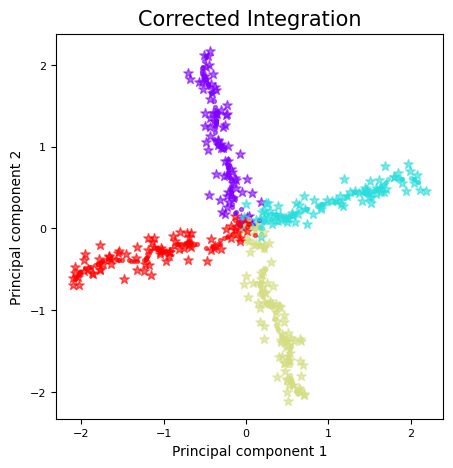

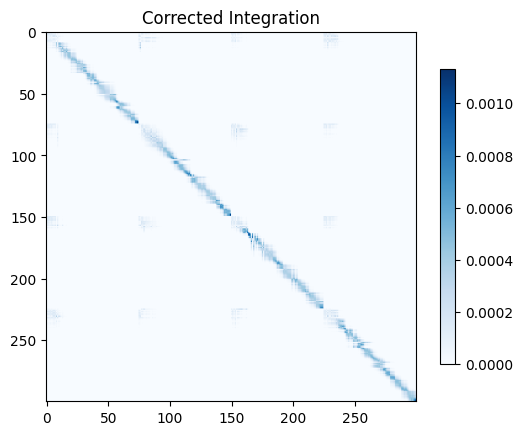

In [8]:
alter_mappings = sonata.map_ambiguous_groups(data1, DiagnoseResult1.ambiguous_labels, DiagnoseResult1.ambiguous_idx)
x_aligned_best, y_aligned_best, best_mapping, _ = sonata_best_acc(x_aligned, y_aligned, label1, label2, alter_mappings, mapping)
     
plt_mapping_by_labels(x_aligned_best, y_aligned_best, label1, label2, title = "Corrected Integration", a = 0.6, show=True)   
plt_heatmap(best_mapping, title="Corrected Integration", show=True)